# Calculates the El Nino Modoki index (EMI)

In [1]:
import sys

In [2]:
print(sys.executable)

/home/nicolasf/anaconda3/envs/pangeo/bin/python


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import pathlib

In [5]:
from datetime import timedelta

In [6]:
import numpy as np
import pandas as pd

In [7]:
from cartopy import crs as ccrs

In [8]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [9]:
from scipy.stats import zscore

In [10]:
import xarray as xr

In [11]:
HOME = pathlib.Path.home()

In [12]:
dpath = HOME.joinpath("research/CPP/indices/data/ERSSTV5")

In [13]:
lfiles_ersst = list(dpath.glob("*.nc"))

In [14]:
lfiles_ersst.sort()

In [15]:
lfiles_ersst[0]

PosixPath('/home/nicolasf/research/CPP/indices/data/ERSSTV5/ersst.v5.185401.nc')

In [16]:
lfiles_ersst[-1]

PosixPath('/home/nicolasf/research/CPP/indices/data/ERSSTV5/ersst.v5.202003.nc')

### keep only 1950 onwards 

In [17]:
start_year = 1950

In [18]:
(start_year - 1854 + 1) * 12

1164

In [19]:
lfiles_ersst = lfiles_ersst[(start_year - 1854) * 12:]

In [20]:
lfiles_ersst[0]

PosixPath('/home/nicolasf/research/CPP/indices/data/ERSSTV5/ersst.v5.195001.nc')

In [21]:
lfiles_ersst[-1]

PosixPath('/home/nicolasf/research/CPP/indices/data/ERSSTV5/ersst.v5.202003.nc')

In [22]:
d = []
for fname in lfiles_ersst:
#     print(f"opening {fname}")
    dset = xr.open_dataset(fname, decode_times=False)
    dset = dset.squeeze() 
    if 'lev' in dset.coords:
        dset = dset.drop('lev')
    dset = dset.sel(lat=slice(-30,30), lon=slice(100,300))
    d.append(dset)

In [23]:
dset = xr.concat(d, dim='time')

In [24]:
dset

<xarray.Dataset>
Dimensions:  (lat: 31, lon: 101, time: 843)
Coordinates:
  * lat      (lat) float64 -30.0 -28.0 -26.0 -24.0 -22.0 ... 24.0 26.0 28.0 30.0
  * lon      (lon) float64 100.0 102.0 104.0 106.0 ... 294.0 296.0 298.0 300.0
  * time     (time) float64 0.0 0.0 0.0 0.0 ... 5.369e+04 5.369e+04 5.369e+04
Data variables:
    sst      (time, lat, lon) float32 21.657005 21.630663 ... 21.737593
    ssta     (time, lat, lon) float32 0.4796524 0.5450363 ... 0.95321846
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.195001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    institution:                NOAA/NESDIS/NCEI/CCOG
    creator_name:               Boyin Huang
    creator_email:              boyin.huang@noaa.gov
    date_created:               2017-06-30T12:18:00Z
    date_modified:              2017-06-30T12:18:00Z
    product_version:            Version 5
    history:                    Fri Jun 30 12:32:44 2017: ncatted -O -a _Fill...
    creator_url:                https://www.ncei.noaa.gov
    license:                    No constraints on data access or use
    time_coverage_start:        1950-01-01T00:00:00Z
    time_coverage_end:          1950-02-01T00:00:00Z
    geospatial_lon_min:         -1.0
    geospatial_lon_max:         359.0
    geospatial_lat_min:         -89.0
    geospatial_lat_max:         89.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  2.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  2.0
    spatial_resolution:         2.0 degree grid
    cdm_data_type:              Grid
    processing_level:           NOAA Level 4
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    keywords:                   Earth Science > Oceans > Ocean Temperature > ...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    project:                    NOAA Extended Reconstructed Sea Surface Tempe...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [25]:
dset['time'] = (('time'), pd.date_range(start=f'{start_year}-01-01', periods=len(dset['time']), freq='MS'))

### calculates the anomalies with respect to the 1981-2010 normal

In [26]:
def demean(x): 
    return x - x.sel(time=slice('1981','2010')).mean(dim='time')

In [27]:
dset_anoms = dset.groupby('time.month').apply(demean)[['sst']]

In [28]:
dom_A = dset_anoms.sel(lat=slice(-10., 10.), lon=slice(165., 220.)).mean(dim='lat').mean(dim='lon')
dom_B = dset_anoms.sel(lat=slice(-15., 5.), lon=slice(250., 290.)).mean(dim='lat').mean(dim='lon')
dom_C = dset_anoms.sel(lat=slice(-10., 20.), lon=slice(125., 145.)).mean(dim='lat').mean(dim='lon')

In [29]:
EMI = dom_A-0.5*dom_B-0.5*dom_C

In [30]:
EMI = EMI.to_dataframe()

In [31]:
EMI.columns = ['EMI_monthly']

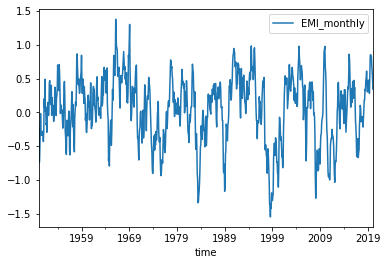

In [32]:
EMI.plot()

### for comparison with the JAMSTEC EMI

In [37]:
url = 'http://www.jamstec.go.jp/frsgc/research/d1/iod/DATA/emi.monthly.txt'

jamstect_EMI = pd.read_table(url, header=None, sep=r'[:, \s*]', skiprows=1, engine='python')

jamstect_EMI.columns = ['year','month','day','time','Box_A','Box_B','Box_C','EMI_jamstec']

jamstect_EMI.index = pd.to_datetime(jamstect_EMI[['year','month','day']])

jamstect_EMI.head()

,year,month,day,time,Box_A,Box_B,Box_C,EMI_jamstec
1870-01-16,1870,1,16,0,-0.236928,-0.962961,0.313880,0.087613
1870-02-16,1870,2,16,0,-0.893361,-0.675769,0.184265,-0.647609
1870-03-16,1870,3,16,0,-0.710367,-0.356447,0.174618,-0.619452
1870-04-16,1870,4,16,0,-0.734068,-0.337298,0.001341,-0.566090
1870-05-16,1870,5,16,0,-0.804244,-0.605928,-0.115931,-0.443315


### shift the index to be the beginning of the month 

In [38]:
jamstect_EMI.index = jamstect_EMI.index.to_pydatetime() - timedelta(days=15)

In [39]:
jamstect_EMI.head()

,year,month,day,time,Box_A,Box_B,Box_C,EMI_jamstec
1870-01-01,1870,1,16,0,-0.236928,-0.962961,0.313880,0.087613
1870-02-01,1870,2,16,0,-0.893361,-0.675769,0.184265,-0.647609
1870-03-01,1870,3,16,0,-0.710367,-0.356447,0.174618,-0.619452
1870-04-01,1870,4,16,0,-0.734068,-0.337298,0.001341,-0.566090
1870-05-01,1870,5,16,0,-0.804244,-0.605928,-0.115931,-0.443315


In [40]:
jamstect_EMI = pd.concat([jamstect_EMI.loc[:,'EMI_jamstec'], EMI.loc[:,'EMI_monthly']], axis=1, join='inner')

### correlation between the JAMSTEC EMI and our newly calculated EMI 

In [41]:
jamstect_EMI.corr()

,EMI_jamstec,EMI_monthly
EMI_jamstec,1.000000,0.959795
EMI_monthly,0.959795,1.000000


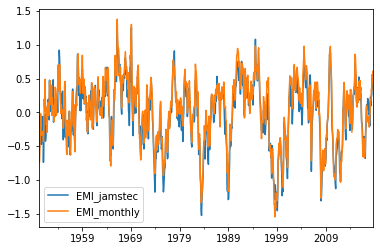

In [42]:
jamstect_EMI.plot()

### calculates the 3 months running means 

In [44]:
EMIs = EMI.rolling(window=3).mean()

In [46]:
EMIs.columns = ['EMI_seasonal']

In [47]:
EMI = pd.concat([EMI, EMIs], axis=1)

In [49]:
EMI

,EMI_monthly,EMI_seasonal
time,,
1950-01-01,-0.218625,NaN
1950-02-01,-0.326593,NaN
1950-03-01,-0.738638,-0.427952
1950-04-01,-0.601962,-0.555731
1950-05-01,-0.270306,-0.536969
...,...,...
2019-11-01,0.686897,0.775338
2019-12-01,0.605196,0.707239
2020-01-01,0.484194,0.592096


### shift to end of month 

In [50]:
EMI.index = EMI.index + pd.offsets.MonthEnd(0)

### saves to disk 

In [52]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/EMI")

In [54]:
EMI.to_csv(opath.joinpath("EMI.csv"))